# 1.导包

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# 2.读取数据

In [3]:
train_data = pd.read_csv("data/train_data.csv")
test_data = pd.read_csv("data/test_data.csv")

In [5]:
train_data = train_data.iloc[:-3]

# 3.数据预处理

In [7]:
# 数值特征
numerical_features_to_scale = ['casual', 'registered']  # 需要归一化的特征
numerical_features_no_scale = ['temp', 'atemp', 'hum', 'windspeed']  # 不需要归一化的特征
target_column = 'cnt'

# 数据预处理
train_data.fillna(0, inplace=True)
test_data.fillna(0, inplace=True)

# 初始化归一化器
scaler_cnt = MinMaxScaler()
scaler_features = MinMaxScaler()

# 归一化目标变量
scaler_cnt.fit(train_data[[target_column]])
train_data[target_column] = scaler_cnt.transform(train_data[[target_column]])
test_data[target_column] = scaler_cnt.transform(test_data[[target_column]])

# 归一化特征
scaler_features.fit(train_data[numerical_features_to_scale])
train_data[numerical_features_to_scale] = scaler_features.transform(train_data[numerical_features_to_scale])
test_data[numerical_features_to_scale] = scaler_features.transform(test_data[numerical_features_to_scale])

In [9]:
# 时间特征处理
def preprocess_time_features(data):
    data['hour_sin'] = np.sin(2 * np.pi * data['hr'] / 24.0)
    data['hour_cos'] = np.cos(2 * np.pi * data['hr'] / 24.0)
    data['weekday_sin'] = np.sin(2 * np.pi * data['weekday'] / 7.0)
    data['weekday_cos'] = np.cos(2 * np.pi * data['weekday'] / 7.0)
    data['season_sin'] = np.sin(2 * np.pi * data['season'] / 4.0)
    data['season_cos'] = np.cos(2 * np.pi * data['season'] / 4.0)
    data['month_sin'] = np.sin(2 * np.pi * data['mnth'] / 12.0)
    data['month_cos'] = np.cos(2 * np.pi * data['mnth'] / 12.0)
    return data
train_data = preprocess_time_features(train_data)
test_data = preprocess_time_features(test_data)

# 4.特征提取

In [11]:
# 特征列表
features = [
    'hour_sin', 'hour_cos',  # 小时周期
    'weekday_sin', 'weekday_cos',  # 周周期
    'season_sin', 'season_cos',  # 季节周期
    'month_sin', 'month_cos',  # 月份周期
    'yr', 'holiday', 'workingday', 'weathersit',  # 分类特征
    'temp', 'atemp', 'hum', 'windspeed',  # 数值特征
    'casual', 'registered'  # 归一化特征
]

X_train = train_data[features]
X_test = test_data[features]

y_train = train_data[target_column]
y_test = test_data[target_column]

# 5.划分数据集

In [13]:
def create_dataset(X, y, seq_len=96, output_len=240, step=1):
    features, targets = [], []
    for i in range(0, len(X) - seq_len - output_len + 1, step):
        features.append(X.iloc[i:i+seq_len].values)
        targets.append(y.iloc[i+seq_len:i+seq_len+output_len].values)
    return np.array(features), np.array(targets)

train_dataset, train_labels = create_dataset(X_train, y_train, seq_len=96, output_len=240)
test_dataset, test_labels = create_dataset(X_test, y_test, seq_len=96, output_len=240)

In [17]:
# 自定义数据集
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 数据加载器
train_loader = DataLoader(CustomDataset(train_dataset, train_labels), batch_size=64, shuffle=True)
test_loader = DataLoader(CustomDataset(test_dataset, test_labels), batch_size=64, shuffle=False)

# 6. 模型架构

In [19]:
# 定义 Transformer 模型
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_heads=8, num_layers=4, output_size=240, dropout=0.3):
        super(TransformerModel, self).__init__()
        self.input_fc = nn.Linear(input_size, hidden_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_size, nhead=num_heads, dropout=dropout)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads, dropout=dropout)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, src, tgt):
        src = self.input_fc(src)
        tgt = self.input_fc(tgt)
        src = src.permute(1, 0, 2)
        tgt = tgt.permute(1, 0, 2)
        memory = self.encoder(src)
        output = self.decoder(tgt, memory)
        output = output.permute(1, 0, 2)
        output = self.fc(output[:, -1, :])
        return output

# 7.训练并保存最佳模型

In [21]:
# 初始化权重函数
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [23]:
# 多次实验函数
def run_experiments_transformer(model_class, train_loader, test_loader, input_size, epochs=50, num_experiments=5):
    test_losses = []

    for i in range(num_experiments):
        print(f"Starting Experiment {i + 1}/{num_experiments}")

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model_class(input_size=input_size, hidden_size=256, num_heads=8, num_layers=4, output_size=240).to(device)

        # 初始化模型权重
        model.apply(init_weights)

        criterion = torch.nn.SmoothL1Loss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.005, steps_per_epoch=len(train_loader), epochs=epochs)

        best_loss = float('inf')

        for epoch in range(epochs):
            model.train()
            train_loss = 0.0
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                tgt = batch_X[:, -1:, :]
                optimizer.zero_grad()
                outputs = model(batch_X, tgt)
                loss = criterion(outputs, batch_y)
                
                # 梯度裁剪
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # 调整裁剪阈值

                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_loss /= len(train_loader)

            model.eval()
            test_loss = 0.0
            with torch.no_grad():
                for batch_X, batch_y in test_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    tgt = batch_X[:, -1:, :]
                    outputs = model(batch_X, tgt)
                    loss = criterion(outputs, batch_y)
                    test_loss += loss.item()
            test_loss /= len(test_loader)

            scheduler.step()

            print(f"Experiment {i + 1}, Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")

            if test_loss < best_loss:
                best_loss = test_loss
                torch.save(model.state_dict(), f"transformer_best_model_{i + 1}.pth")
                print(f"Experiment {i + 1}: Best model saved with Test Loss: {test_loss:.6f}")

        test_losses.append(best_loss)

    avg_loss = sum(test_losses) / num_experiments
    std_loss = np.std(test_losses)
    print("\nAll Experiments Completed!")
    print(f"Test Losses: {test_losses}")
    print(f"Average Test Loss: {avg_loss:.6f}")
    print(f"Standard Deviation of Test Loss: {std_loss:.6f}")

# 调用多次实验函数
run_experiments_transformer(
    model_class=TransformerModel,
    train_loader=train_loader,
    test_loader=test_loader,
    input_size=train_dataset.shape[2], 
    epochs=30,
    num_experiments=5
)

Starting Experiment 1/5


D:\anaconda3\envs\gc\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
D:\anaconda3\envs\gc\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Experiment 1, Epoch 1/30, Train Loss: 0.073504, Test Loss: 0.019850
Experiment 1: Best model saved with Test Loss: 0.019850
Experiment 1, Epoch 2/30, Train Loss: 0.026114, Test Loss: 0.014657
Experiment 1: Best model saved with Test Loss: 0.014657
Experiment 1, Epoch 3/30, Train Loss: 0.014051, Test Loss: 0.019436
Experiment 1, Epoch 4/30, Train Loss: 0.010277, Test Loss: 0.020152
Experiment 1, Epoch 5/30, Train Loss: 0.008683, Test Loss: 0.021600
Experiment 1, Epoch 6/30, Train Loss: 0.007886, Test Loss: 0.018245
Experiment 1, Epoch 7/30, Train Loss: 0.007368, Test Loss: 0.016686
Experiment 1, Epoch 8/30, Train Loss: 0.006980, Test Loss: 0.014084
Experiment 1: Best model saved with Test Loss: 0.014084
Experiment 1, Epoch 9/30, Train Loss: 0.006640, Test Loss: 0.012810
Experiment 1: Best model saved with Test Loss: 0.012810
Experiment 1, Epoch 10/30, Train Loss: 0.006332, Test Loss: 0.011431
Experiment 1: Best model saved with Test Loss: 0.011431
Experiment 1, Epoch 11/30, Train Loss: 

D:\anaconda3\envs\gc\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Experiment 2, Epoch 1/30, Train Loss: 0.071699, Test Loss: 0.020201
Experiment 2: Best model saved with Test Loss: 0.020201
Experiment 2, Epoch 2/30, Train Loss: 0.026314, Test Loss: 0.015747
Experiment 2: Best model saved with Test Loss: 0.015747
Experiment 2, Epoch 3/30, Train Loss: 0.014755, Test Loss: 0.019260
Experiment 2, Epoch 4/30, Train Loss: 0.010833, Test Loss: 0.021161
Experiment 2, Epoch 5/30, Train Loss: 0.009010, Test Loss: 0.020309
Experiment 2, Epoch 6/30, Train Loss: 0.008086, Test Loss: 0.020725
Experiment 2, Epoch 7/30, Train Loss: 0.007495, Test Loss: 0.017743
Experiment 2, Epoch 8/30, Train Loss: 0.007039, Test Loss: 0.016692
Experiment 2, Epoch 9/30, Train Loss: 0.006682, Test Loss: 0.016242
Experiment 2, Epoch 10/30, Train Loss: 0.006293, Test Loss: 0.013568
Experiment 2: Best model saved with Test Loss: 0.013568
Experiment 2, Epoch 11/30, Train Loss: 0.005858, Test Loss: 0.015263
Experiment 2, Epoch 12/30, Train Loss: 0.005402, Test Loss: 0.012850
Experiment 2:

# 8. 通过模型进行预测

In [27]:
def predict_average(models, model_class, input_size, test_loader):
    """
    使用多个模型进行预测并求平均值。

    :param models: 模型文件路径列表
    :param model_class: 模型类
    :param input_size: 模型输入大小
    :param test_loader: 测试数据加载器
    :return: 平均预测结果和真实值
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_predictions = []

    # 遍历所有模型，逐个加载并进行预测
    for model_path in models:
        print(f"Loading model: {model_path}")
        # 初始化模型，设置 output_size=96
        model = model_class(input_size=input_size, hidden_size=256, num_heads=8, num_layers=4, output_size=240).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))  # 加载模型权重
        model.eval()

        predictions = []
        actuals = []
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)

                # 构造 tgt（目标序列的初始部分）
                tgt = batch_X[:, -1:, :]  # 假设使用最后一个时间步的数据作为起始

                # 获取预测值
                outputs = model(batch_X, tgt).cpu().numpy()

                predictions.extend(outputs)
                actuals.extend(batch_y.cpu().numpy())

        all_predictions.append(np.array(predictions))  # 将预测结果存储

    # 将所有预测结果求平均
    average_predictions = np.mean(all_predictions, axis=0)  # 逐样本求平均
    return average_predictions, np.array(actuals)

# 定义模型文件路径列表
models = [f"transformer_best_model_{i+1}.pth" for i in range(5)]

# 调用函数进行预测
average_predictions, actuals = predict_average(
    models=models,
    model_class=TransformerModel,
    input_size=train_dataset.shape[2],  # 替换为你的输入大小
    test_loader=test_loader
)

# 打印结果
print("Predictions shape:", average_predictions.shape)
print("Actuals shape:", actuals.shape)


Loading model: transformer_best_model_1.pth


D:\anaconda3\envs\gc\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\lenovo\AppData\Local\Temp\ipykernel_34332\2327265511.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to 

Loading model: transformer_best_model_2.pth
Loading model: transformer_best_model_3.pth
Loading model: transformer_best_model_4.pth
Loading model: transformer_best_model_5.pth
Predictions shape: (1825, 240)
Actuals shape: (1825, 240)


# 9.计算MSE和MAE

In [29]:
# 反归一化预测和实际值
average_predictions = scaler_cnt.inverse_transform(average_predictions)
actuals = scaler_cnt.inverse_transform(actuals)
# 每个样本的 MSE 和 MAE
mse_per_sample = np.mean((average_predictions - actuals) ** 2, axis=1)  # 每个样本的 MSE
mae_per_sample = np.mean(np.abs(average_predictions - actuals), axis=1)  # 每个样本的 MAE

# 计算均值和标准差
mse_mean = np.mean(mse_per_sample)
mse_std = np.std(mse_per_sample)
mae_mean = np.mean(mae_per_sample)
mae_std = np.std(mae_per_sample)

print(f"Mean Squared Error (MSE): {mse_mean:.6f} ± {mse_std:.6f}")
print(f"Mean Absolute Error (MAE): {mae_mean:.6f} ± {mae_std:.6f}")



Mean Squared Error (MSE): 17214.937500 ± 20921.830078
Mean Absolute Error (MAE): 82.856094 ± 45.663582


# 10.绘图

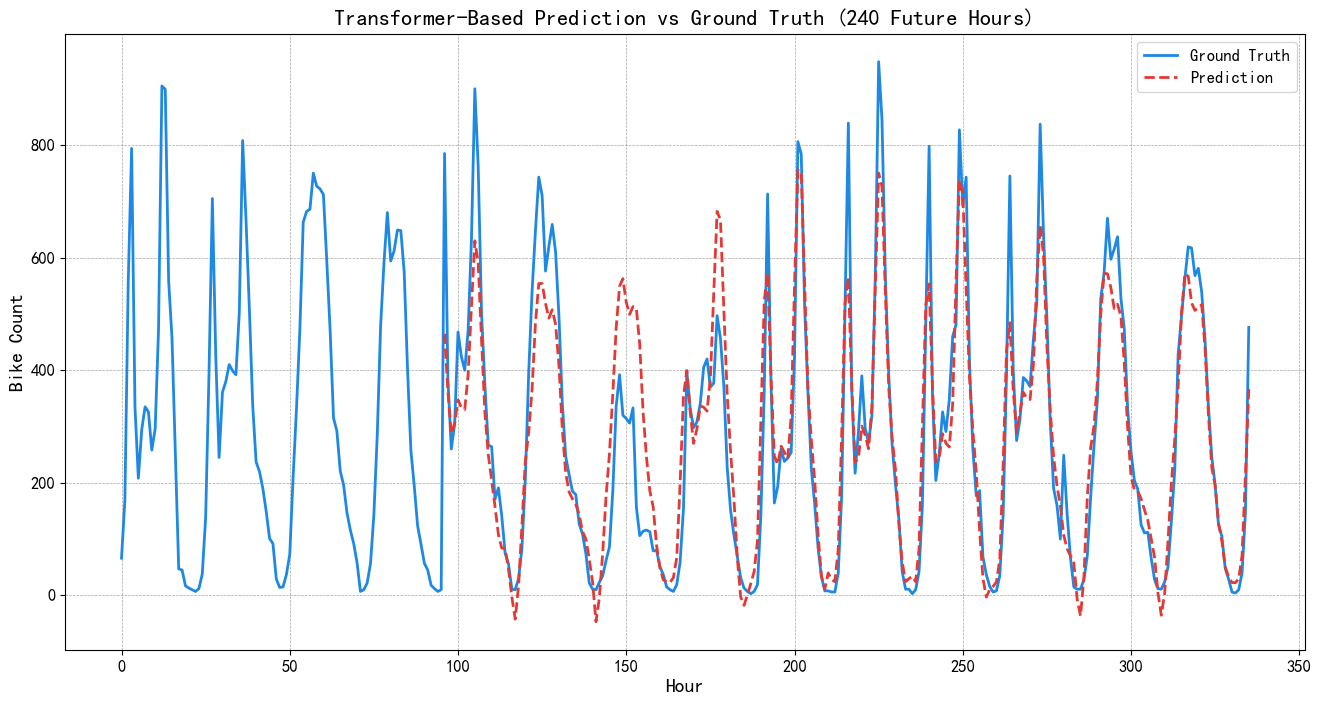

In [31]:
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)
past_96_hours = scaler_cnt.inverse_transform(y_train.iloc[-96:].values.reshape(-1, 1)).flatten()
future_240_hours_actuals = actuals[0]  # 真实值
future_240_hours_predictions = average_predictions[0]  # 预测值

# 绘制图表
plt.figure(figsize=(16, 8))  # 调整图表大小

# 绘制真实值曲线（过去96小时和未来240小时）
plt.plot(
    range(336),  # 96 + 240 = 336小时
    np.concatenate((past_96_hours, future_240_hours_actuals)), 
    label="Ground Truth", color="#1E88E5", linewidth=2  # 深蓝色
)

# 绘制预测值曲线（未来240小时）
plt.plot(
    range(96, 336),  # 从96到336（仅预测部分）
    future_240_hours_predictions, 
    label="Prediction", color="#E53935", linestyle="--", linewidth=2  # 深红色
)

# 添加图例和标题
plt.legend(fontsize=12, loc="upper right")  # 图例在右上角
plt.title("Transformer-Based Prediction vs Ground Truth (240 Future Hours)", fontsize=16, fontweight="bold")
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Bike Count", fontsize=14)

# 调整坐标轴样式
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

# 保存并展示图像
plt.savefig("transformer_bike_rental_predictions_long_term.png", dpi=300, bbox_inches='tight')
plt.show()